# Final dataset analysis using training patches

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch
import json

## Helper functions

In [2]:
def summarize_dataset(df, cat2color):

    cell_type_cols = list(cat2color.keys())

    # Define a dictionary to store results
    results = {}

    # Iterate through each set and calculate the stats
    for set_name in df['set'].unique().tolist() + ['Total']:
        # Subset for each set or whole dataset
        subset = df if set_name == 'Total' else df[df['set'] == set_name]

        # Calculate stats
        total_patches = subset['img'].nunique()
        cell_counts = subset[cell_type_cols].sum()
        total_cells = cell_counts.sum()
        patch_counts_per_type = subset.groupby('img')[cell_type_cols].sum().apply(lambda x: x > 0).sum()

        # Calculate percentages per cell type
        percentages = (cell_counts / total_cells * 100).round(2)

        # Store results in the dictionary
        results[set_name] = {
            'Total Patches': total_patches,
            'Total Cells': total_cells,
            **{f"{cell} Count": cell_counts[cell] for cell in cell_type_cols},
            **{f"{cell} Patch Count": patch_counts_per_type[cell] for cell in cell_type_cols},
            **{f"{cell} (%)": percentages[cell] for cell in cell_type_cols}
        }

    # Create a DataFrame for display
    summary_df = pd.DataFrame(results).T

    # Organize columns for better readability
    ordered_columns = (
        ['Total Patches', 'Total Cells'] +
        [f"{cell} Count" for cell in cell_type_cols] +
        [f"{cell} Patch Count" for cell in cell_type_cols] +
        [f"{cell} (%)" for cell in cell_type_cols]
    )
    summary_df = summary_df[ordered_columns]

    # Order the rows (train, valid, test, total)
    summary_df = summary_df.loc[['train', 'valid', 'test', 'Total']]

    # Function to format the numbers
    def format_columns(col):
        # Apply formatting based on the column name
        return col.apply(lambda x: f"{x:,.1f}" if isinstance(x, (int, float)) and "(%)" in col.name else f"{x:,.0f}" if isinstance(x, (int, float)) else x)


    # Format the numbers in the DataFrame
    styled_summary_df = summary_df.apply(format_columns)

    # Function to apply colors to specific column groups
    def highlight_columns(col):
        if col.name in ['Total Patches', 'Total Cells']:
            return ['background-color: lightblue'] * len(col)
        elif "Count" in col.name and "Patch" not in col.name:
            return ['background-color: lightgreen'] * len(col)
        elif "Patch Count" in col.name:
            return ['background-color: lightcoral'] * len(col)
        elif "(%)" in col.name:
            return ['background-color: lightyellow'] * len(col)
        else:
            return [''] * len(col)

    # Apply the highlighting to each column (not row-wise)
    styled_summary_df = styled_summary_df.style.apply(highlight_columns, axis=0)

    # Display the summary table
    display(styled_summary_df)

    # Do not hide columns for better visibility
    pd.set_option('display.max_columns', 100)

    return summary_df

In [3]:
def plot_dataset(df, group_col, cat2color, type_col, set):

    # Extract cell type columns and colors
    cell_type_cols = list(cat2color.keys())
    cell_type_colors = {k: [c / 255 for c in v] for k, v in cat2color.items()}  # Normalize RGB to 0-1

    # Subset the data based on the set
    if set == "train":
        df_plot = df[df["set"] == "train"].copy()
    elif set == "valid":
        df_plot = df[df["set"] == "valid"].copy()
    elif set == "test":
        df_plot = df[df["set"] == "test"].copy()
    else:
        df_plot = df.copy()

    # Handle if group_col = type_col
    if group_col == type_col:
        group_col = group_col + "_"
        df_plot[group_col] = df_plot[type_col]

    # Aggregate cell counts by group_col and cell type
    slide_totals = df_plot.groupby([group_col, type_col])[cell_type_cols].sum().reset_index()
    slide_totals["Total"] = slide_totals[cell_type_cols].sum(axis=1)
    
    # Sort by slide ID in alphabetical order
    slide_totals = slide_totals.sort_values(by=group_col, ascending=True)

    # Set up the plot
    fig, ax = plt.subplots(figsize=(10, 8))

    # Plot the stacked bar chart
    bottom = None
    for cell_type in cell_type_cols:
        ax.barh(
            slide_totals[group_col],
            slide_totals[cell_type],
            left=bottom,
            color=cell_type_colors[cell_type],  # Custom colors for cell types
            label=f"{cell_type} ({slide_totals[cell_type].sum():,.0f})"
        )
        bottom = slide_totals[cell_type] if bottom is None else bottom + slide_totals[cell_type]

    # Customize x-axis and slide labels
    ax.set_xlabel("cell count")
    ax.set_ylabel(group_col)
    ax.set_title(f"Set: {set}")
    ax.invert_yaxis()

    # Generate a color map for the 'type' column
    unique_types = slide_totals[type_col].unique()
    type_colors = dict(zip(unique_types, sns.color_palette("Dark2", len(unique_types))))

    # Color slide labels according to the 'type' column
    slide_labels = [f"{slide} ({total:,.0f})" for slide, total in zip(slide_totals[group_col], slide_totals["Total"])]
    slide_colors = slide_totals[type_col].map(type_colors)

    ax.set_yticks(range(len(slide_totals)))
    ax.set_yticklabels(slide_labels, ha='right', fontsize=10)

    for label, color in zip(ax.get_yticklabels(), slide_colors):
        label.set_color(color)

    # Adjust legend appearance for cell type
    custom_legend = [Patch(facecolor=cell_type_colors[cell_type], edgecolor="black", label=f"{cell_type} ({slide_totals[cell_type].sum():,.0f})")
                     for cell_type in cell_type_cols]
    ax.legend(handles=custom_legend, title="Cell Type", loc="upper center", bbox_to_anchor=(0.5, -0.12),
              ncol=3, frameon=True, framealpha=1, facecolor='none', edgecolor='black', fontsize=10, title_fontsize=12)

    plt.tight_layout()
    plt.show()

In [4]:
def plot_all_metrics(df_metrics):

    metrics = ['Dice', 'Jaccard', 'bPQ']

    plt.figure(figsize=(9, 3))

    for i, metric in enumerate(metrics, 1):
        plt.subplot(1, 3, i)
        sns.histplot(df_metrics[metric], bins=30, kde=True, color='blue')
        plt.title(f'{metric}')
        plt.xlabel(metric)
        plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()

## ds_1

In [5]:
dataset_id = 'ds_1'
cell_cat_id = 'ct_1'

In [6]:
df = pd.read_csv(f'/Volumes/DD_FGS/MICS/data_HE2CellType/HE2CT/training_datasets/{dataset_id}/informations/infos_{dataset_id}.csv')
df.head()

,T_NK,B_Plasma,Myeloid,Blood_vessel,Fibroblast_Myofibroblast,Epithelial,Specialized,Melanocyte,Dead,img,type,Dice,Jaccard,bPQ,slide_id,set
0,0,0,1,0,1,0,2,0,0,heart_s0_362.png,Heart,0.777565,0.636079,0.480884,heart_s0,train
1,0,0,0,2,1,0,4,0,0,heart_s0_363.png,Heart,0.709650,0.549967,0.378748,heart_s0,train
2,0,0,0,1,2,0,1,0,0,heart_s0_364.png,Heart,0.813963,0.686289,0.603601,heart_s0,train
3,0,0,0,2,2,0,0,0,0,heart_s0_365.png,Heart,0.833883,0.715094,0.647057,heart_s0,train
4,0,0,0,0,0,0,1,0,0,heart_s0_366.png,Heart,0.820359,0.695431,0.712304,heart_s0,test


In [7]:
df.isna().sum().sum()

0

/Users/felicie-giraud-sauveur/miniforge3/envs/cellvit/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/felicie-giraud-sauveur/miniforge3/envs/cellvit/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/felicie-giraud-sauveur/miniforge3/envs/cellvit/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


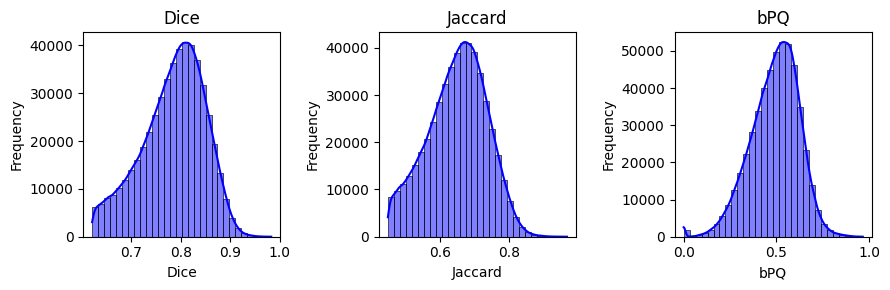

In [8]:
plot_all_metrics(df)

In [9]:
with open(f"/Volumes/DD_FGS/MICS/data_HE2CellType/CT_DS/annots/annot_dicts_{cell_cat_id}/cat2color.json", "r") as f:
    cat2color = json.load(f)
cat2color

{'T_NK': [255, 15, 15],
 'B_Plasma': [255, 143, 15],
 'Myeloid': [255, 211, 15],
 'Blood_vessel': [70, 128, 0],
 'Fibroblast_Myofibroblast': [156, 255, 36],
 'Epithelial': [57, 208, 133],
 'Specialized': [69, 237, 255],
 'Melanocyte': [22, 169, 223],
 'Dead': [143, 143, 143]}

In [10]:
summary_df = summarize_dataset(df, cat2color)

,Total Patches,Total Cells,T_NK Count,B_Plasma Count,Myeloid Count,Blood_vessel Count,Fibroblast_Myofibroblast Count,Epithelial Count,Specialized Count,Melanocyte Count,Dead Count,T_NK Patch Count,B_Plasma Patch Count,Myeloid Patch Count,Blood_vessel Patch Count,Fibroblast_Myofibroblast Patch Count,Epithelial Patch Count,Specialized Patch Count,Melanocyte Patch Count,Dead Patch Count,T_NK (%),B_Plasma (%),Myeloid (%),Blood_vessel (%),Fibroblast_Myofibroblast (%),Epithelial (%),Specialized (%),Melanocyte (%),Dead (%)
train,"305,081","11,852,577","1,737,599","1,156,754","1,476,829","915,106","1,582,669","4,038,943","46,018","190,151","708,508","152,584","67,024","242,131","158,274","225,835","195,638","14,531","9,370","107,292",14.7,9.8,12.5,7.7,13.3,34.1,0.4,1.6,6.0
valid,"101,699","3,944,972","581,390","382,991","492,757","303,403","529,402","1,338,900","15,166","63,995","236,968","51,000","22,451","80,650","52,656","75,064","64,964","4,849","3,148","35,686",14.7,9.7,12.5,7.7,13.4,33.9,0.4,1.6,6.0
test,"101,703","3,952,344","577,174","385,082","494,074","306,835","531,251","1,339,426","15,278","64,927","238,297","50,943","22,359","80,590","52,855","75,428","65,252","4,843","3,243","35,904",14.6,9.7,12.5,7.8,13.4,33.9,0.4,1.6,6.0
Total,"508,483","19,749,893","2,896,163","1,924,827","2,463,660","1,525,344","2,643,322","6,717,269","76,462","319,073","1,183,773","254,527","111,834","403,371","263,785","376,327","325,854","24,223","15,761","178,882",14.7,9.8,12.5,7.7,13.4,34.0,0.4,1.6,6.0


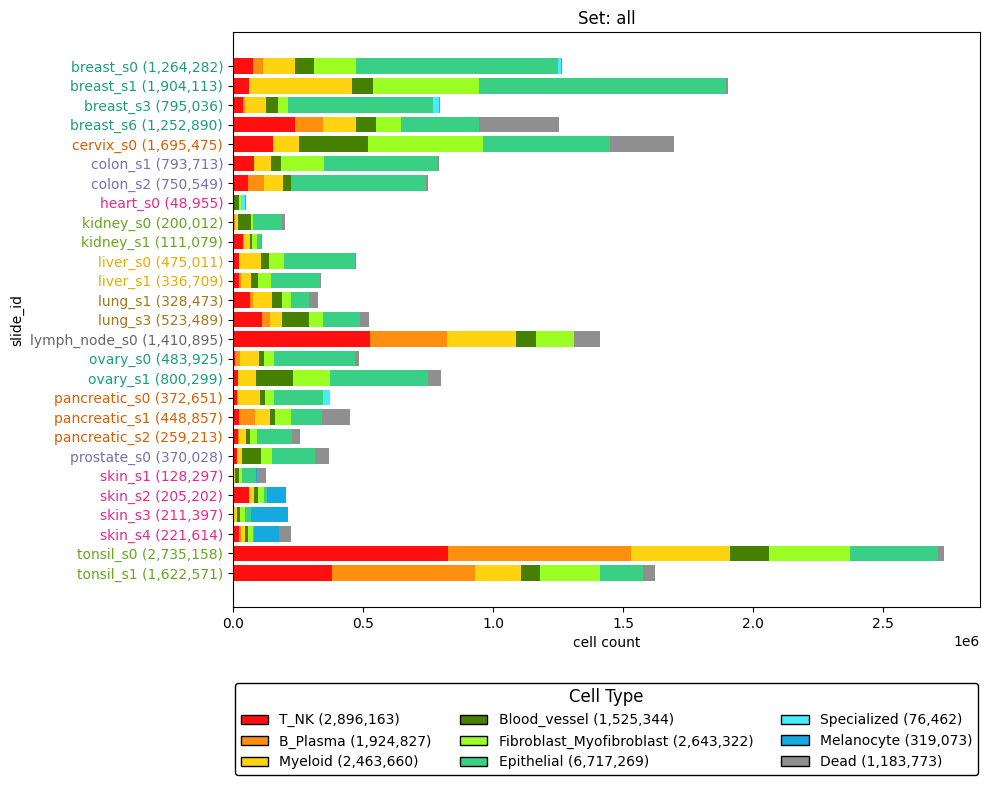

In [11]:
plot_dataset(df, 'slide_id', cat2color, 'type', 'all')

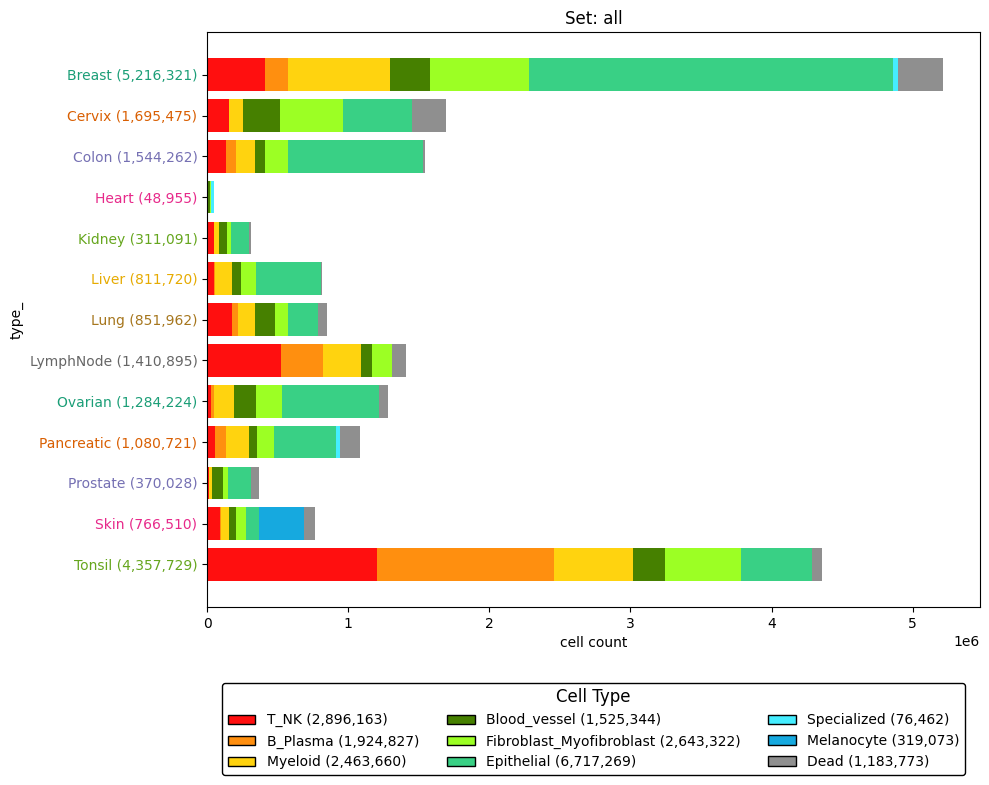

In [12]:
plot_dataset(df, 'type', cat2color, 'type', 'all')

## ds_2

In [2]:
dataset_id = 'ds_2'
cell_cat_id = 'ct_1'

In [3]:
df = pd.read_csv(f'/Volumes/DD_FGS/MICS/data_HE2CellType/HE2CT/training_datasets/{dataset_id}/informations/infos_{dataset_id}.csv')
df.head()

,T_NK,B_Plasma,Myeloid,Blood_vessel,Fibroblast_Myofibroblast,Epithelial,Specialized,Melanocyte,Dead,img,type,Dice,Jaccard,bPQ,slide_id,set
0,0,0,0,2,2,0,0,0,0,heart_s0_365.png,Heart,0.833883,0.715094,0.647057,heart_s0,train
1,0,0,0,1,0,0,0,0,0,heart_s0_437.png,Heart,0.920128,0.852071,0.852069,heart_s0,test
2,0,0,0,0,0,0,3,0,0,heart_s0_480.png,Heart,0.851594,0.741544,0.726854,heart_s0,train
3,0,0,0,3,1,0,5,0,0,heart_s0_483.png,Heart,0.843884,0.729930,0.542883,heart_s0,valid
4,0,0,0,2,2,0,10,0,0,heart_s0_486.png,Heart,0.827749,0.706119,0.655565,heart_s0,test


In [4]:
df.isna().sum().sum()

0

/Users/felicie-giraud-sauveur/miniforge3/envs/cellvit/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/felicie-giraud-sauveur/miniforge3/envs/cellvit/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/felicie-giraud-sauveur/miniforge3/envs/cellvit/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


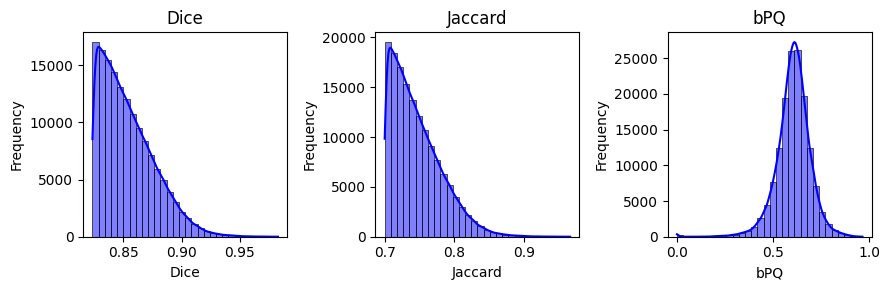

In [9]:
plot_all_metrics(df)

In [10]:
with open(f"/Volumes/DD_FGS/MICS/data_HE2CellType/CT_DS/annots/annot_dicts_{cell_cat_id}/cat2color.json", "r") as f:
    cat2color = json.load(f)
cat2color

{'T_NK': [255, 15, 15],
 'B_Plasma': [255, 143, 15],
 'Myeloid': [255, 211, 15],
 'Blood_vessel': [70, 128, 0],
 'Fibroblast_Myofibroblast': [156, 255, 36],
 'Epithelial': [57, 208, 133],
 'Specialized': [69, 237, 255],
 'Melanocyte': [22, 169, 223],
 'Dead': [143, 143, 143]}

In [11]:
summary_df = summarize_dataset(df, cat2color)

,Total Patches,Total Cells,T_NK Count,B_Plasma Count,Myeloid Count,Blood_vessel Count,Fibroblast_Myofibroblast Count,Epithelial Count,Specialized Count,Melanocyte Count,Dead Count,T_NK Patch Count,B_Plasma Patch Count,Myeloid Patch Count,Blood_vessel Patch Count,Fibroblast_Myofibroblast Patch Count,Epithelial Patch Count,Specialized Patch Count,Melanocyte Patch Count,Dead Patch Count,T_NK (%),B_Plasma (%),Myeloid (%),Blood_vessel (%),Fibroblast_Myofibroblast (%),Epithelial (%),Specialized (%),Melanocyte (%),Dead (%)
train,"89,390","3,237,554","382,423","252,024","337,444","217,626","364,743","1,516,282","20,590","65,102","81,320","39,732","16,187","66,452","42,711","58,637","64,105","7,927","3,238","21,774",11.8,7.8,10.4,6.7,11.3,46.8,0.6,2.0,2.5
valid,"29,803","1,078,216","130,419","83,985","113,311","73,028","121,580","501,468","7,073","20,533","26,819","13,103","5,403","22,158","14,176","19,362","21,378","2,653","1,057","7,253",12.1,7.8,10.5,6.8,11.3,46.5,0.7,1.9,2.5
test,"29,803","1,075,861","127,084","84,048","112,631","72,047","120,868","503,726","6,879","21,935","26,643","13,214","5,366","22,216","14,097","19,482","21,410","2,641","1,104","7,165",11.8,7.8,10.5,6.7,11.2,46.8,0.6,2.0,2.5
Total,"148,996","5,391,631","639,926","420,057","563,386","362,701","607,191","2,521,476","34,542","107,570","134,782","66,049","26,956","110,826","70,984","97,481","106,893","13,221","5,399","36,192",11.9,7.8,10.4,6.7,11.3,46.8,0.6,2.0,2.5


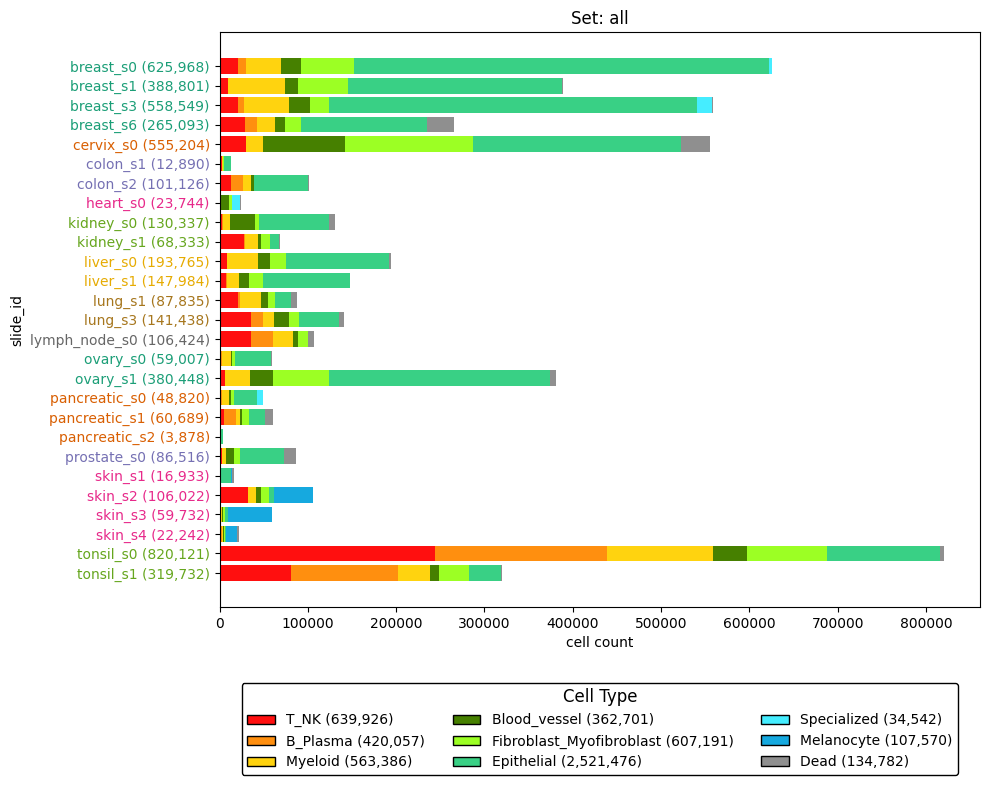

In [12]:
plot_dataset(df, 'slide_id', cat2color, 'type', 'all')

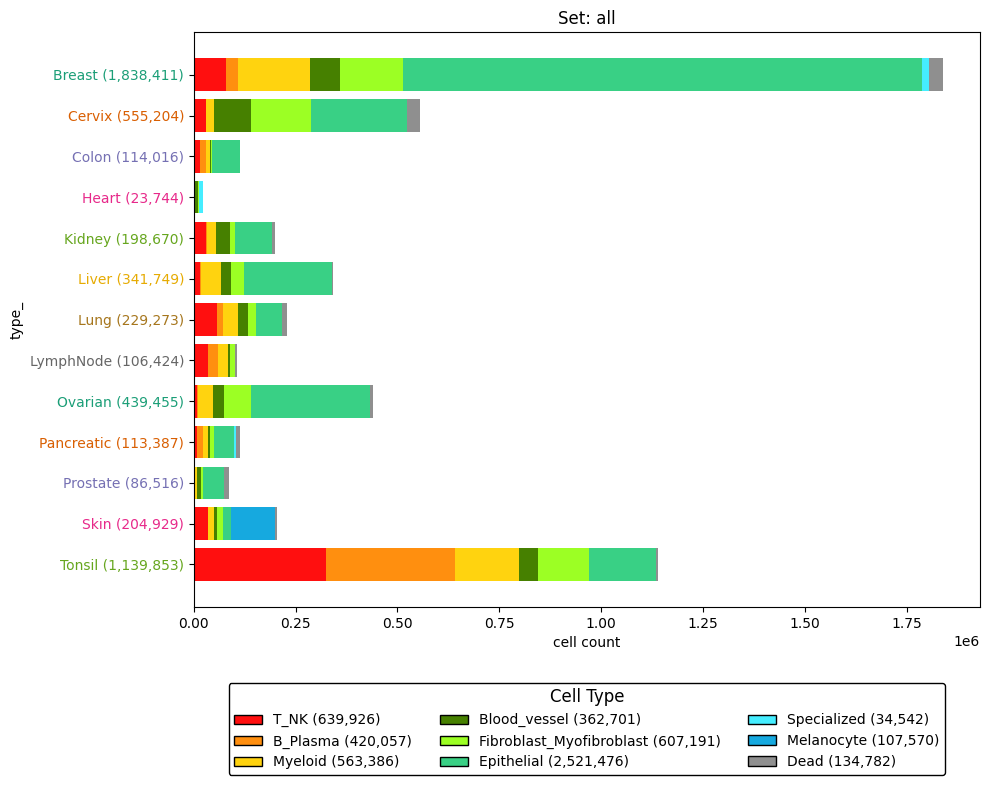

In [13]:
plot_dataset(df, 'type', cat2color, 'type', 'all')

## ds_3

In [5]:
dataset_id = 'ds_3'
cell_cat_id = 'ct_3'

In [6]:
df = pd.read_csv(f'/Volumes/DD_FGS/MICS/data_HE2CellType/HE2CT/training_datasets/{dataset_id}/informations/infos_{dataset_id}.csv')
df.head()

,Epithelial,Melanocyte,Immune,Stromal,Other,img,type,Dice,Jaccard,bPQ,slide_id,set
0,0,0,0,4,0,heart_s0_365.png,Heart,0.833883,0.715094,0.647057,heart_s0,valid
1,0,0,0,1,0,heart_s0_437.png,Heart,0.920128,0.852071,0.852069,heart_s0,test
2,0,0,0,0,3,heart_s0_480.png,Heart,0.851594,0.741544,0.726854,heart_s0,train
3,0,0,0,4,5,heart_s0_483.png,Heart,0.843884,0.729930,0.542883,heart_s0,train
4,0,0,0,4,10,heart_s0_486.png,Heart,0.827749,0.706119,0.655565,heart_s0,test


In [7]:
df.isna().sum().sum()

0

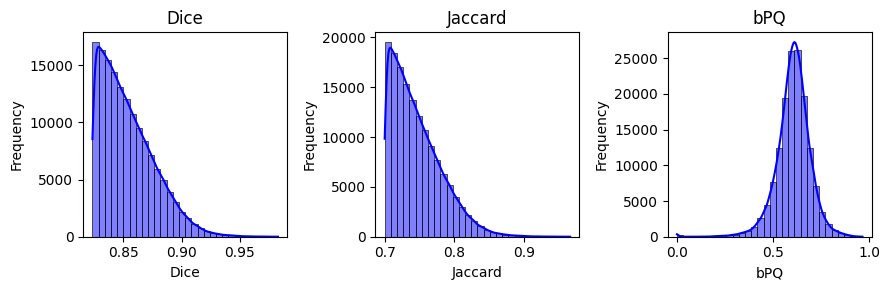

In [8]:
plot_all_metrics(df)

In [9]:
with open(f"/Volumes/DD_FGS/MICS/data_HE2CellType/CT_DS/annots/annot_dicts_{cell_cat_id}/cat2color.json", "r") as f:
    cat2color = json.load(f)
cat2color

{'Immune': [255, 143, 15],
 'Stromal': [156, 255, 36],
 'Epithelial': [57, 208, 133],
 'Melanocyte': [22, 169, 223],
 'Other': [143, 143, 143]}

In [10]:
summary_df = summarize_dataset(df, cat2color)

,Total Patches,Total Cells,Immune Count,Stromal Count,Epithelial Count,Melanocyte Count,Other Count,Immune Patch Count,Stromal Patch Count,Epithelial Patch Count,Melanocyte Patch Count,Other Patch Count,Immune (%),Stromal (%),Epithelial (%),Melanocyte (%),Other (%)
train,"89,390","3,235,309","970,807","582,320","1,516,691","64,419","101,072","72,068","69,398","64,183","3,222","29,223",30.0,18.0,46.9,2.0,3.1
valid,"29,803","1,078,544","329,172","194,114","499,738","21,586","33,934","24,116","23,152","21,298","1,089","9,749",30.5,18.0,46.3,2.0,3.1
test,"29,803","1,077,778","323,390","193,458","505,047","21,565","34,318","24,038","22,992","21,412","1,088","9,759",30.0,17.9,46.9,2.0,3.2
Total,"148,996","5,391,631","1,623,369","969,892","2,521,476","107,570","169,324","120,222","115,542","106,893","5,399","48,731",30.1,18.0,46.8,2.0,3.1


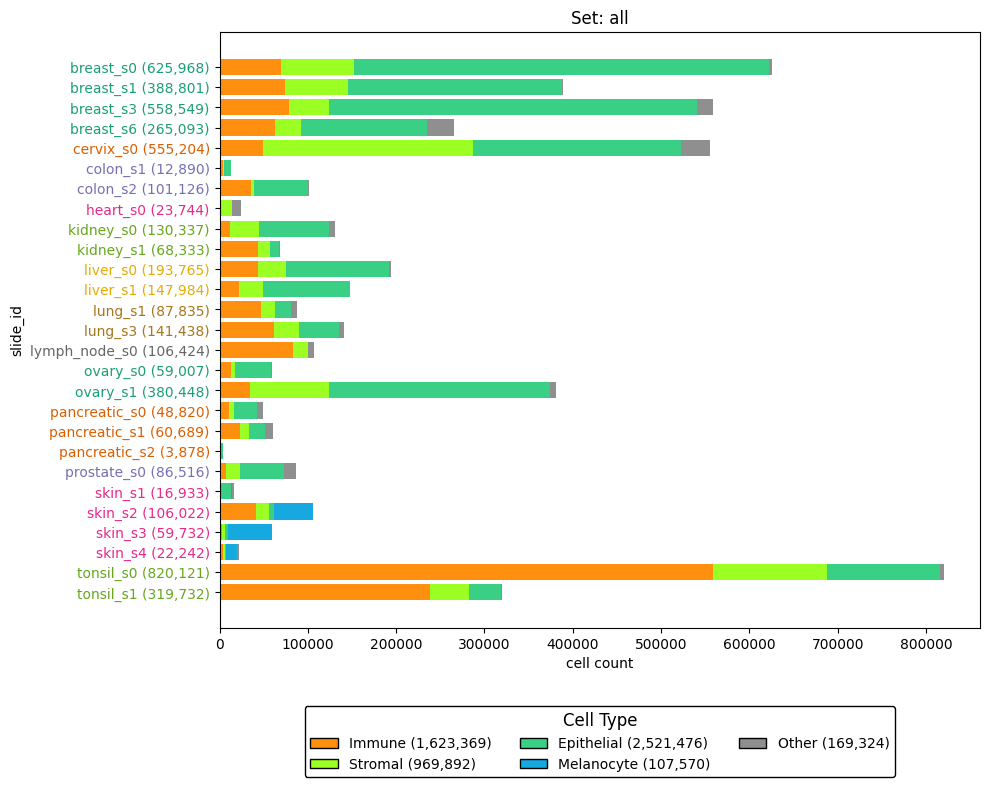

In [11]:
plot_dataset(df, 'slide_id', cat2color, 'type', 'all')

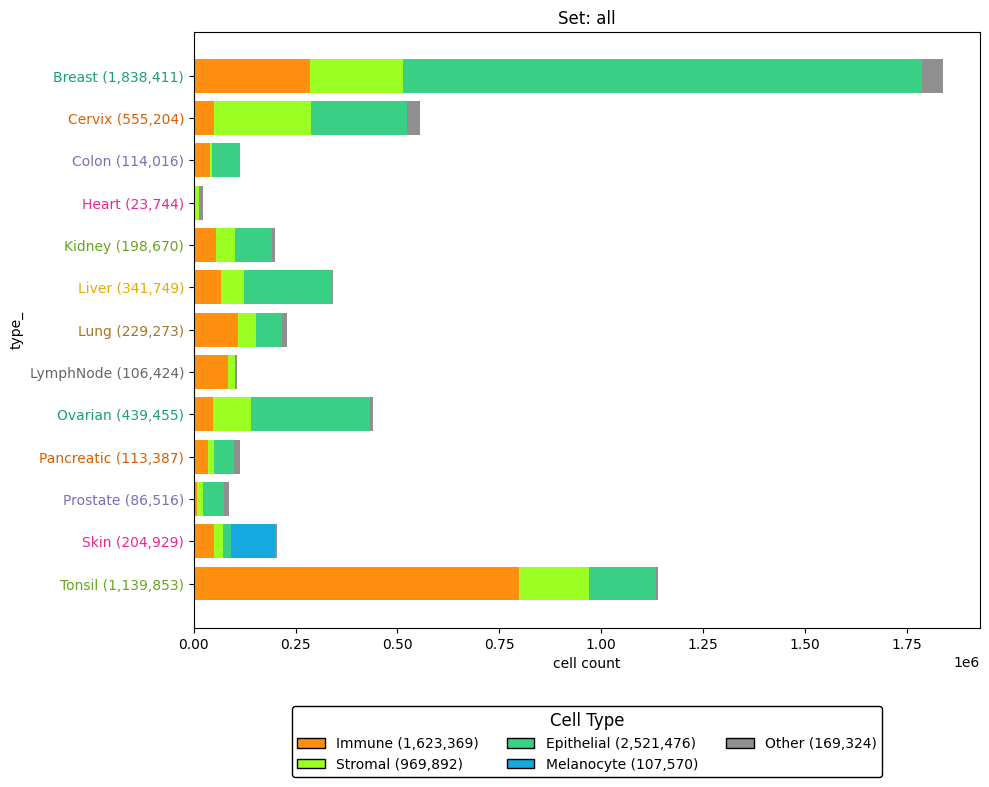

In [12]:
plot_dataset(df, 'type', cat2color, 'type', 'all')

## ds_4

In [5]:
dataset_id = 'ds_4'
cell_cat_id = 'ct_3'

In [6]:
df = pd.read_csv(f'/Volumes/DD_FGS/MICS/data_HE2CellType/HE2CT/training_datasets/{dataset_id}/informations/infos_{dataset_id}.csv')
df.head()

,Epithelial,Melanocyte,Immune,Stromal,Other,img,type,Dice,Jaccard,bPQ,slide_id,set
0,0,0,1,1,2,heart_s0_362.png,Heart,0.777565,0.636079,0.480884,heart_s0,valid
1,0,0,0,3,4,heart_s0_363.png,Heart,0.709650,0.549967,0.378748,heart_s0,train
2,0,0,0,3,1,heart_s0_364.png,Heart,0.813963,0.686289,0.603601,heart_s0,test
3,0,0,0,4,0,heart_s0_365.png,Heart,0.833883,0.715094,0.647057,heart_s0,train
4,0,0,0,0,1,heart_s0_366.png,Heart,0.820359,0.695431,0.712304,heart_s0,valid


In [7]:
df.isna().sum().sum()

0

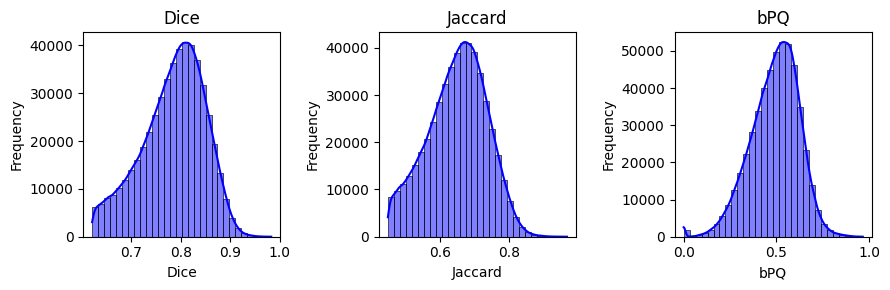

In [8]:
plot_all_metrics(df)

In [9]:
with open(f"/Volumes/DD_FGS/MICS/data_HE2CellType/CT_DS/annots/annot_dicts_{cell_cat_id}/cat2color.json", "r") as f:
    cat2color = json.load(f)
cat2color

{'Immune': [255, 143, 15],
 'Stromal': [156, 255, 36],
 'Epithelial': [57, 208, 133],
 'Melanocyte': [22, 169, 223],
 'Other': [143, 143, 143]}

In [10]:
summary_df = summarize_dataset(df, cat2color)

,Total Patches,Total Cells,Immune Count,Stromal Count,Epithelial Count,Melanocyte Count,Other Count,Immune Patch Count,Stromal Patch Count,Epithelial Patch Count,Melanocyte Patch Count,Other Patch Count,Immune (%),Stromal (%),Epithelial (%),Melanocyte (%),Other (%)
train,"305,101","11,849,471","4,373,028","2,498,468","4,029,220","191,280","757,475","260,004","255,977","195,479","9,456","121,061",36.9,21.1,34.0,1.6,6.4
valid,"101,691","3,944,406","1,452,561","830,349","1,346,239","64,414","250,843","86,463","85,115","65,249","3,180","40,359",36.8,21.1,34.1,1.6,6.4
test,"101,691","3,956,016","1,459,061","839,849","1,341,810","63,379","251,917","86,679","85,248","65,126","3,125","40,323",36.9,21.2,33.9,1.6,6.4
Total,"508,483","19,749,893","7,284,650","4,168,666","6,717,269","319,073","1,260,235","433,146","426,340","325,854","15,761","201,743",36.9,21.1,34.0,1.6,6.4


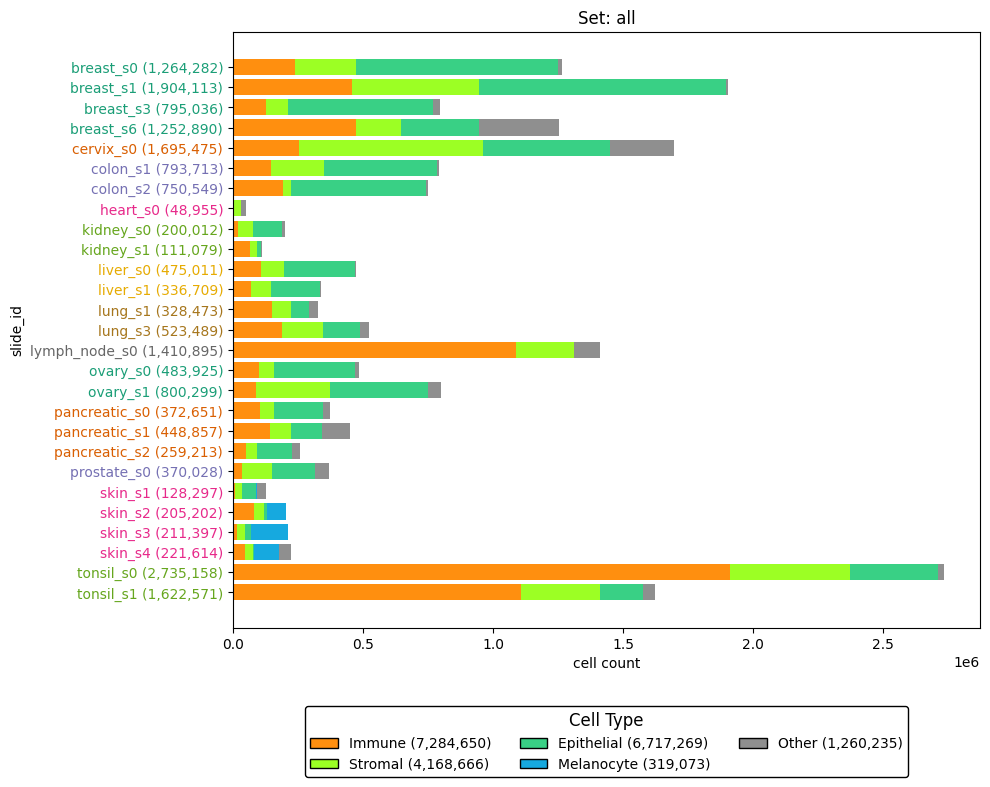

In [11]:
plot_dataset(df, 'slide_id', cat2color, 'type', 'all')

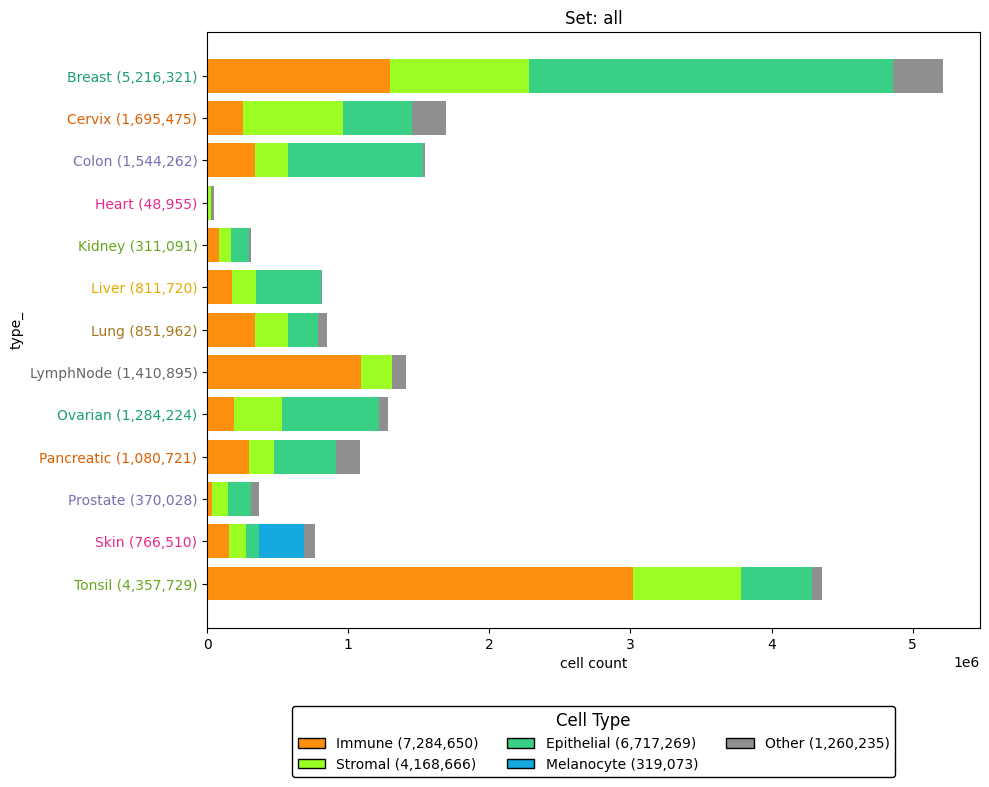

In [12]:
plot_dataset(df, 'type', cat2color, 'type', 'all')